# Replay trajectory analysis (linear track)

## imports

In [ ]:
import math

import numpy as np

import fklab.signals.smooth as smooth
import fklab.replay
import fklab.statistics.core

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## utilities

In [ ]:
# plot posterior probability distribution as an image
def plot_posterior(
    p,
    time=None,
    pos=None,
    ax=None,
    cmap="gray_r",
    vmin=0,
    vmax=None,
    colorbar=True,
    ylabel="position",
    xlabel="time",
):

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if time is None:
        time = (0, p.shape[0])
    else:
        time = time[[0, -1]]

    if pos is None:
        pos = (0, p.shape[1])
    else:
        pos = pos[[0, -1]]

    vmin = math.floor(10 * np.min(p)) / 10 if vmin is None else float(vmin)
    vmax = math.ceil(10 * np.max(p)) / 10 if vmax is None else float(vmax)

    img = ax.imshow(
        p.T,
        extent=[*time, *pos],
        aspect="auto",
        cmap=cmap,
        interpolation="none",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set(ylabel=ylabel if ylabel else "", xlabel=xlabel if xlabel else "")
    ax.set_xlim(time)
    ax.set_ylim(pos)

    if colorbar:
        if isinstance(colorbar, bool):
            cax = None
        else:
            cax = colorbar
        plt.colorbar(img, ax=ax, cax=cax, label="probability")

    return img, ax


# plot multiple posteriors
def plot_multi_posterior(
    p, time=None, pos=None, ax=None, labels=None, vmin=0, vmax=None, colorbar=True
):

    if not isinstance(p, (tuple, list)):
        if p.ndim == 3:
            n = p.shape[2]
            p = [p[:, :, k] for k in range(n)]
        else:
            p = [p]

    n = len(p)

    if ax is None:
        fig, ax = plt.subplots(1, n, sharey=True)

    if labels is None:
        labels = [
            "",
        ] * n

    m = np.max([np.max(k) for k in p])
    vmax = np.ceil(10 * m) / 10 if vmax is None else vmax

    for k, label in enumerate(labels):
        img, _ = plot_posterior(
            p[k],
            time=time,
            pos=pos,
            ax=ax[k],
            vmin=vmin,
            vmax=vmax,
            colorbar=False,
            ylabel="position" if k == 0 else "",
        )
        ax[k].set(title=label)

    if colorbar:
        if isinstance(colorbar, bool):
            cax = None
        else:
            cax = colorbar
        plt.colorbar(img, ax=ax, cax=cax, label="probability")

    return ax


# plot radon transform
def plot_radon_line_fit(result, ax=None, cmap="viridis", colorbar=True):

    if result.radon is None:
        raise ValueError("No radon transform available in result.")

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    img = ax.imshow(
        result.radon,
        aspect="auto",
        interpolation="none",
        origin="lower",
        extent=[*result.rho_vector[[0, -1]], *result.theta_vector[[0, -1]]],
        cmap=cmap,
    )

    ax.set(ylabel="theta [radians]", xlabel="rho")

    if colorbar:
        if isinstance(colorbar, bool):
            cax = None
        else:
            cax = colorbar
        plt.colorbar(img, ax=ax, cax=cax, label="summed probability")

    ax.set(title="Radon Transform")

    ax.plot(result.rho, result.theta, "ro")

    ax.set_xlim(result.rho_vector[[0, -1]])
    ax.set_ylim(result.theta_vector[[0, -1]])

    return ax

## construct example posterior distribution with replay trajectory

In [ ]:
start_time, dt, ntime = 0.1, 0.02, 11
start_pos, dx, npos = 100, 10, 29

time_bins = np.arange(ntime) * dt + start_time
pos_bins = np.arange(npos) * dx + start_pos

time_vector = (time_bins[0:-1] + time_bins[1:]) / 2.0
pos_vector = (pos_bins[0:-1] + pos_bins[1:]) / 2.0

# provide lower boundary of bins (rather than centers)
# to do: double check if this is correct inside radon transform code
# time_vector = time_bins[:-1]
# pos_vector = pos_bins[:-1]

np.random.seed(748)
noise = 1

# inbound
inbound = np.hstack(
    [
        noise * np.random.exponential(1, (10, 8)),
        smooth.smooth1d(
            np.diag(np.random.exponential(3, (10)) * 3.0),
            axis=1,
            kernel="gaussian",
            bandwidth=0.5,
        )
        + noise * np.random.exponential(1, (10, 10)),
        noise * np.random.exponential(1, (10, 10)),
    ]
)

# outbound
outbound = inbound * np.random.uniform(0.1, 0.3, size=inbound.shape)

# full data
data = np.stack([inbound, outbound], axis=2)
data = data / np.sum(data, axis=(1, 2), keepdims=True)

pos_marginal = np.sum(data, axis=2)

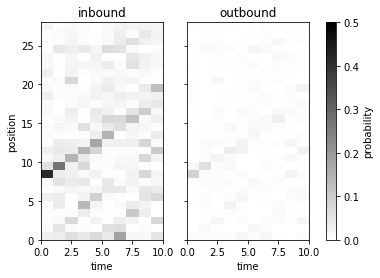

In [ ]:
plot_multi_posterior(data, labels=["inbound", "outbound"]);

## Replay trajectory analysis

### fit line with radon transform

In [ ]:
fcn = fklab.replay.radon_line_fitter(return_radon=True, integrate=3)
score, result = fcn(pos_marginal, time=time_vector, pos=pos_vector)

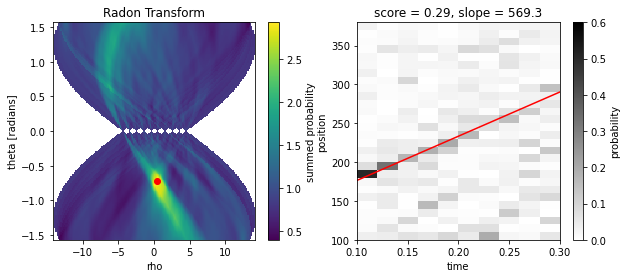

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_radon_line_fit(result, ax=ax[0])
plot_posterior(pos_marginal, time=time_bins[[0, -1]], pos=pos_bins[[0, -1]], ax=ax[1])
ax[1].axline((0, result.intercept), slope=result.slope, color="red")
ax[1].set(title="score = {:.2f}, slope = {:.1f}".format(result.score, result.slope));

### fit line with isotonic regression

In [ ]:
fcn = fklab.replay.isotonic_regressor(
    weighted=True, loss="L1", statistic="posterior", integrate=3
)
score, result = fcn(pos_marginal, time=time_vector, pos=pos_vector)

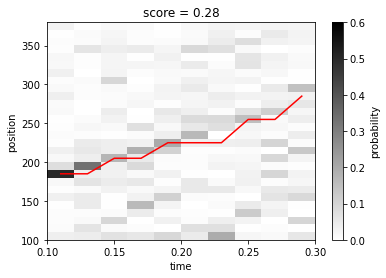

In [ ]:
_, ax = plot_posterior(pos_marginal, time=time_bins, pos=pos_bins)
ax.plot(time_vector, result.yhat, "r")
ax.set(title="score = {:.2f}".format(score));

### significance of fit: shuffle distributions

#### spatial shuffles

In [ ]:
# spatial roll (or cycle) randomization
p = fklab.replay.rand_spatial(pos_marginal, method="roll")

# compute isotonic regression
fcn = fklab.replay.isotonic_regressor(weighted=True, loss="L1", statistic="posterior")
original_score, original_result = fcn(pos_marginal, time=time_vector, pos=pos_vector)
rand_score, rand_result = fcn(p, time=time_vector, pos=pos_vector)

# plot
ax = plot_multi_posterior(
    [pos_marginal, p], time=time_bins, pos=pos_bins, labels=["original", "shuffled"]
)

ax[0].plot(time_vector, original_result.yhat, "r")
ax[0].set(title="score = {:.2f}".format(original_score))
ax[1].plot(time_vector, rand_result.yhat, "r")
ax[1].set(title="score = {:.2f}".format(rand_score));

#### temporal shuffle

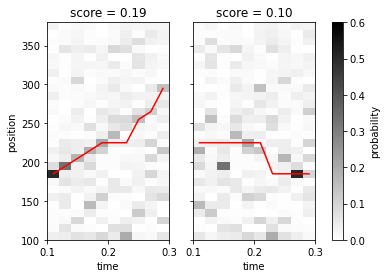

In [ ]:
# temporal (time bin) randomization
p = fklab.replay.rand_temporal(pos_marginal)

# compute isotonic regression
fcn = fklab.replay.isotonic_regressor(weighted=True, loss="L1", statistic="posterior")
original_score, original_result = fcn(pos_marginal, time=time_vector, pos=pos_vector)
rand_score, rand_result = fcn(p, time=time_vector, pos=pos_vector)

# plot
ax = plot_multi_posterior(
    [pos_marginal, p], time=time_bins, pos=pos_bins, labels=["original", "shuffled"]
)

ax[0].plot(time_vector, original_result.yhat, "r")
ax[0].set(title="score = {:.2f}".format(original_score))
ax[1].plot(time_vector, rand_result.yhat, "r")
ax[1].set(title="score = {:.2f}".format(rand_score));

#### pseudo event shuffle

In [ ]:
# pseudo event randomization
# note that we should really use a much larger population of posteriors
# than from a single putative replay event
p = fklab.replay.rand_pseudo(pos_marginal, len(pos_marginal))

# compute isotonic regression
fcn = fklab.replay.isotonic_regressor(weighted=True, loss="L1", statistic="posterior")
original_score, original_result = fcn(pos_marginal, time=time_vector, pos=pos_vector)
rand_score, rand_result = fcn(p, time=time_vector, pos=pos_vector)

# plot
ax = plot_multi_posterior(
    [pos_marginal, p], time=time_bins, pos=pos_bins, labels=["original", "shuffled"]
)

ax[0].plot(time_vector, original_result.yhat, "r")
ax[0].set(title="score = {:.2f}".format(original_score))
ax[1].plot(time_vector, rand_result.yhat, "r")
ax[1].set(title="score = {:.2f}".format(rand_score));

### shuffle distributions

In [ ]:
# works for rand_spatial and rand_temporal
shuffles = fklab.replay.posterior_shuffle(
    [pos_marginal],
    fklab.replay.rand_spatial,
    fklab.replay.isotonic_regressor(weighted=True, loss="L1", statistic="posterior"),
    real_statistics=None,
    N=200,
    test=False,
)

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.kdeplot(shuffles[0], ax=ax, fill=True, color="orange")
ax.axvline(original_score, color="black")
ax.set(xlim=(0, None), xlabel="score")
pval = fklab.statistics.core.monte_carlo_pvalue(shuffles[0], original_score)
ax.set(title="p={:.3f}".format(pval));

In [ ]:
shuffles = fklab.replay.posterior_pseudo_shuffle(
    [pos_marginal],
    fklab.replay.isotonic_regressor(weighted=True, loss="L1", statistic="posterior"),
    nbins=None,
    N=1000,
    return_more=False,
)

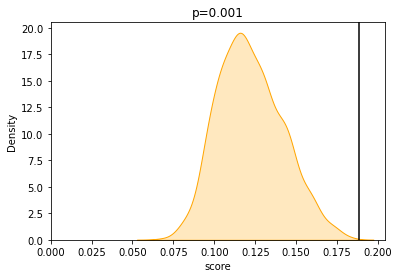

In [ ]:
fig, ax = plt.subplots(1, 1)
sns.kdeplot(shuffles[len(pos_marginal)], ax=ax, fill=True, color="orange")
ax.axvline(original_score, color="black")
ax.set(xlim=(0, None), xlabel="score")
pval = fklab.statistics.core.monte_carlo_pvalue(
    shuffles[len(pos_marginal)], original_score
)
ax.set(title="p={:.3f}".format(pval));

### all in one replay trajectory analysis

In [ ]:
# choose your replay trajectory fitting function
fcn = fklab.replay.isotonic_regressor(
    weighted=True, loss="L1", statistic="posterior", integrate=3
)
# fcn = fklab.replay.radon_line_fitter(return_radon=True, integrate=3)

# perform fitting and shuffles
# choose which and how many shuffle you would like to perform
(scores, extra), summary, shuffles = fklab.replay.trajectory_fit(
    [pos_marginal],
    fcn=fcn,
    population=None,
    time=[time_vector],
    pos=pos_vector,
    nshuffles=dict(space_cycle=500, time_shuffle=500),
    # the following arguments are to test periodically if we should
    # continue testing more shuffles. Set test is False to always
    # perform as many shuffles as requested.
    test=True,
    test_interval=50,
    test_pvalue=0.01,
    tails="right",
)

In [ ]:
print("p-value space cycle shuffle = {:.3f}".format(summary["space_cycle"][0]["p"]))
print("p-value time shuffle = {:.3f}".format(summary["time_shuffle"][0]["p"]))

p-value space cycle shuffle = 0.006
p-value time shuffle = 0.004


### Replay order score (forward/reverse replay)

In [ ]:
replay_score, order_score_shuffles, pval = fcn.order_score(
    data[:, :, 0], data[:, :, 1], extra[0], pos_vector, nshuffle=500
)

print(
    "replay order score = {:.2f} ({} replay); p={:.3f}".format(
        replay_score, "reverse" if replay_score < 0 else "forward", pval
    )
)

replay order score = -0.67 (reverse replay); p=0.002


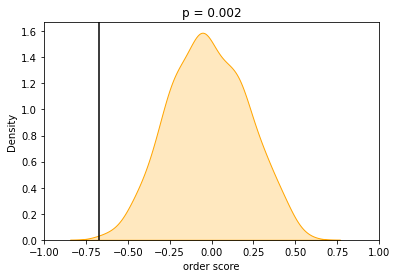

In [ ]:
fig, ax = plt.subplots(1, 1)

sns.kdeplot(order_score_shuffles, fill=True, color="orange", ax=ax)

ax.axvline(replay_score, color="black")
ax.set(title="p = {:.3f}".format(pval), xlim=(-1, 1), xlabel="order score");